# Training (prot + mRNA)

#### Last edit 7/20/2025

## Set up

### Package imports

In [1]:
# Import packages
import os
import copy
from pathlib import Path
import numpy as np
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
import pandas as pd
import random
from pdb import set_trace

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, matthews_corrcoef

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

### GPU

In [2]:
# Check to see if the GPU is available and store it as a variable so tensors can be moved to it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print('Is cuda available?:', torch.cuda.is_available())
print('cuda version:', torch.version.cuda)
dev = "cuda:0"

Using device: cuda
Is cuda available?: True
cuda version: 11.7


### Variables and Hyperparameters

In [3]:
# Create run name
Run_Name = 'prot+mRNA' # change run_name before running

# Paths
label_path = '/home/ec2-user/Jul2025/labels/' # label folder with all the labels
dataset_folder_path = '/home/ec2-user/Jul2025/processed_dataset3/' # dataset folder with all the processed proteome and mRNA data
model_folder_path = '/home/ec2-user/Jul2025/saved_models/' # model folder with all the models
fig_bank_path = '/home/ec2-user/Jul2025/NN_figure_bank/' # figure bank folder with all the figures
cv_folder_path = '/home/ec2-user/Jul2025/NN_CV_bank/' # cross-validation folder with all the cross-validation results

# Define the Model
Model = 'PixelPreserve' # 'PixelPreserve' are the options

# Dataset
Set = 'Protein + mRNA' # Define the dataset to use, 'Protein', 'mRNA', or 'Protein + mRNA' are the options

# Image size
Canvas_Size = 18

# Seed number
Seed = 43

# Validation fraction
Validation_Fraction = 0.2

# Standard deviation for add-noise transformation
StandardDeviation = 0.005 # 0.005 so far is better

# Learning rate scheduler
Learner_rate = 1e-4

# Optimizer
Weight_Decay = 0.0001 # L2 regulator
#  it works by adding a penalty to the loss function, which discourages large weights in the model; penalizes for too many weights - helps prevent overfitting
#  the penalty is calculated as weight_decay * weight^2, and it's added to the loss.
#  1e-4 or 1e-3 gives higher acc

# Batch size
Batch_size = 64

# Epoch amount
epochs = 100

### Protein, mRNA dataframe, localization label set up

In [4]:
# Open the proteomics data and only keep genes (rows) that are fully quantified
PFP = 'K_PD_synthetic_kde_june.csv' # synthetic data
PD = pd.read_csv(dataset_folder_path+PFP)

# Data set wrangling
PD.index = PD.loc[:,'Index']
PD = PD.loc[:,PD.columns!='Index']
PD.dropna(inplace=True)

# Open the mRNA data and only keep genes (rows) that are fully quantified
MFP = 'K_MD_synthetic_kde_june.csv'
MD = pd.read_csv(dataset_folder_path + MFP)

# Data set wrangling
MD.index = MD.loc[:,'Index']
MD = MD.loc[:,MD.columns!='Index']
MD = MD.drop_duplicates()
MD.dropna(inplace=True)

In [5]:
# Open the labels data
LFP = 'markers.txt'
LD = pd.read_csv(filepath_or_buffer=label_path+LFP,sep='\t')
# Data set wrangling
LD.index = LD.loc[:,'Protein']
LD = LD.loc[:,LD.columns!='Protein']

In [6]:
# Select the localization labels that are both common in the proteomics and mRNA data
common_genes = set(PD.index).intersection(set(MD.index))
# Select only the common genes
LD = LD.loc[LD.index.isin(common_genes),:]

print('Number of total labels in Krug dataset')
print(len(LD.index))
print(LD['Localization'].value_counts())

Number of total labels in Krug dataset
2693
Localization
Cytosol         1036
Secretory        769
Nucleus          624
Mitochondria     264
Name: count, dtype: int64


### Set seed function

In [7]:
def set_seed(seed):
    random.seed(seed) # set random seed for python
    np.random.seed(seed) # set random seed for numpy
    torch.manual_seed(seed) # set random seed for CPU
    rs = RandomState(MT19937(SeedSequence(seed))) # seed for numpy
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed) # set random seed for all GPUs
    torch.backends.cudnn.deterministic = True # set to True to get reproducible results
    torch.backends.cudnn.benchmark = False # set to False to get reproducible results

### Pixel coordinates and RGB tensor generation functions

In [8]:
def gen_horizontal_coords(n, num_points):
    """
    Generate coordinates for a horizontal pattern starting from the top-left corner.

    Parameters:
    n (int): Size of the canvas (n x n).
    num_points (int): Number of points to generate in the horizontal pattern.

    Returns:
    list: List of (x, y) coordinates in horizontal order.
    """
    coords = [(x, y) for x in range(n) for y in range(n)]
    return coords[:num_points]

def create_rgb_tensors(set, interleaved_array):
    """
    Create RGB tensors from abundance data using the specified pattern.
    
    Parameters:
    set (str): Dataset used for plotting ('Protein', 'mRNA', 'Protein + mRNA').
    df1 (pd.DataFrame): DataFrame containing normalized abundance data.
    df2 (pd.DataFrame): DataFrame containing normalized abundance data.
    
    Returns:
    torch.Tensor: RGB tensor.
    """

    interleaved_array = interleaved_array.flatten()
    num_pixels = len(interleaved_array)
    
    # Generate coordinates based on the pattern, spiral or horizontal arrangment
    coords = gen_horizontal_coords(Canvas_Size, num_pixels)

    # Create RGB tensor
    rgb_tensor = np.zeros((Canvas_Size, Canvas_Size, 3), dtype=np.float32)
    for i, (x, y) in enumerate(coords):
        if i < len(interleaved_array):
            value = interleaved_array[i]
            # Assign colors based on the value, if abundance > 1, set it to red, if abundance < 0, set it to blue.
            #if value > 1:
            #    rgb_tensor[x, y] = [255, 0, 0]  # Red for value > 1
            #elif value < 0:
            #    rgb_tensor[x, y] = [0, 0, 255]  # Blue for value < 0
            #else:
            rgb_tensor[x, y] = [255 * value, 0, 255 * (1 - value)]

    return torch.from_numpy(rgb_tensor.transpose(2, 0, 1))  # Convert to CHW format for PyTorch

### Custom Transformation

In [9]:
# Custom transformation to add noise to the data
class AddNoise:
    def __init__(self, set, mean=0, std=0.005):
        self.set = set
        self.mean = mean
        self.std = std

    def __call__(self, array1, array2):
        if self.set == 'Protein + mRNA':
            noise1 = np.random.normal(self.mean, self.std, array1.shape)
            noise2 = np.random.normal(self.mean, self.std, array2.shape)

            return array1 + noise1, array2 + noise2    

        else: # suitable for Protein or mRNA only because same noise will be applied twice
            noise = np.random.normal(self.mean, self.std, array1.shape)
        
        return array1 + noise, array2 + noise

### Custom Dataset class

In [10]:
class MyDataset(Dataset):
    def __init__(self, set, data1, data2, indices, labels, transform=None):

        assert data1.loc[indices,:].shape[0] == data2.loc[indices,:].shape[0] == len(labels), \
            "df1, df2, and labels must have the same number of samples (rows)"

        self.set = set
        self.data1 = data1.loc[indices,:]
        self.data2 = data2.loc[indices,:]
        self.indices = indices
        self.labels = labels
        self.transform = transform

    def __getitem__(self, idx):
        data1 = self.data1.iloc[idx].values
        data2 = self.data2.iloc[idx].values

        if self.transform:  
            data1, data2 = self.transform(data1, data2)

        abundance_sum = data1 + data2
        sorted_idx = abundance_sum.argsort()

        # Interleave
        interleaved_data = np.empty((len(data1) + len(data2)), dtype=np.float32)
        interleaved_data[0::2] = data1[sorted_idx]
        interleaved_data[1::2] = data2[sorted_idx]

        # Create RGB tensor
        sample = create_rgb_tensors(self.set, interleaved_data)
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        return sample, label

    def __len__(self):
        return len(self.labels)

    def get_labels(self):
        return self.labels

### Labels to integers

In [11]:
# Labels
localization_labels = LD.loc[:, 'Localization'].values
unique_labels = set(localization_labels)  # Get unique labels
label_to_int = {
    'Cytosol': 0,
    'Mitochondria': 1,
    'Nucleus': 2,
    'Secretory': 3
}
int_to_label = {v: k for k, v in label_to_int.items()}
int_to_label

{0: 'Cytosol', 1: 'Mitochondria', 2: 'Nucleus', 3: 'Secretory'}

## Model training

### Dataloaders

In [12]:
# Set seed to ensure reproducibility
set_seed(Seed)

# Split the data into training and validation sets using the labels indices, random state is set
train_indices, val_indices, train_labels, val_labels = train_test_split(LD.index, localization_labels, test_size=Validation_Fraction, random_state=42, stratify=localization_labels)

# Convert string labels to integers
train_labels = [label_to_int[label] for label in train_labels]
val_labels = [label_to_int[label] for label in val_labels]

# Define the transformation
transformation = AddNoise(set=Set, mean=0, std=StandardDeviation)

# Check Dataset argument to determine which dataset to use
if Set == 'Protein':
    train_dataset = MyDataset(Set, PD, PD, train_indices, train_labels, transform=transformation)
    val_dataset = MyDataset(Set, PD, PD, val_indices, val_labels, transform=None)
elif Set == 'mRNA':
    train_dataset = MyDataset(Set, MD, MD, train_indices, train_labels, transform=transformation)
    val_dataset = MyDataset(Set, MD, MD, val_indices, val_labels, transform=None)
elif Set == 'Protein + mRNA':
    train_dataset = MyDataset(Set, PD, MD, train_indices, train_labels, transform=transformation)
    val_dataset = MyDataset(Set, PD, MD, val_indices, val_labels, transform=None)
else:
    raise ValueError("Set must be 'Protein' or 'mRNA', or 'Protein + mRNA'")

# Create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=Batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=Batch_size, shuffle=False)

### Visualize the tensors in data loader

In [13]:
# Visualize the train data loader to see the transformed tensors
train_batch_images, train_batch_labels = next(iter(train_loader))

# Use first image in the batch
first_image_in_train_batch = train_batch_images[0]
first_label_in_train_batch = train_batch_labels[0]
first_image_in_train_batch

tensor([[[-845.3591, -652.9336, -669.2115, -727.5515, -718.3696, -560.0379,
          -734.4478, -505.3335, -653.7902, -579.1644, -595.6260, -513.8173,
          -621.2123, -441.2752, -563.7823, -483.4427, -781.8401, -256.0868],
         [-514.5085, -490.8091, -609.4535, -377.8891, -506.9899, -477.0467,
          -448.7109, -524.6538, -547.5074, -414.8941, -479.8836, -444.3687,
          -516.5832, -399.0639, -591.8950, -321.7546, -502.9500, -382.0266],
         [-488.5883, -393.7736, -496.3206, -381.0980, -572.1479, -302.6570,
          -475.2669, -395.4721, -728.7764, -138.3246, -453.2860, -401.6679,
          -409.9348, -440.2695, -373.4994, -472.8265, -374.9787, -467.8388],
         [-493.6653, -346.7944, -493.4106, -327.3079, -341.3078, -478.4648,
          -467.6382, -349.4399, -401.7531, -409.1971, -555.7874, -250.8717,
          -458.2579, -346.3047, -363.4578, -440.9196, -360.1862, -440.3961],
         [-327.1375, -468.6104, -353.6574, -433.3062, -326.7173, -452.9959,
        

In [14]:
# Visualize the train data loader to see the transformed tensors
val_batch_images, val_batch_labels = next(iter(val_loader))

# Use first image in the batch
first_image_in_val_batch = val_batch_images[0]
first_label_in_val_batch = val_batch_labels[0]
first_image_in_val_batch

tensor([[[-7.1874e+02, -4.7236e+02, -3.7642e+02, -4.1699e+02, -3.3113e+02,
          -4.5935e+02, -4.0288e+02, -3.8721e+02, -4.6378e+02, -2.2248e+02,
          -2.8991e+02, -3.5326e+02, -3.7995e+02, -2.5382e+02, -3.7920e+02,
          -2.5290e+02, -3.4482e+02, -2.7652e+02],
         [-3.9792e+02, -2.1012e+02, -3.5489e+02, -2.4313e+02, -3.7060e+02,
          -2.2000e+02, -3.1627e+02, -2.5845e+02, -3.5314e+02, -2.1977e+02,
          -3.1298e+02, -2.5124e+02, -1.9963e+02, -3.5069e+02, -2.1797e+02,
          -3.2059e+02, -2.5876e+02, -2.7470e+02],
         [-2.8185e+02, -2.4693e+02, -2.3942e+02, -2.7170e+02, -2.0706e+02,
          -2.8100e+02, -2.8921e+02, -1.9206e+02, -2.3024e+02, -2.4495e+02,
          -3.0195e+02, -1.7257e+02, -2.4724e+02, -2.1918e+02, -1.5642e+02,
          -3.0992e+02, -2.6578e+02, -1.8964e+02],
         [-3.0674e+02, -1.3941e+02, -2.3089e+02, -2.1437e+02, -1.7502e+02,
          -2.6826e+02, -9.2732e+00, -4.0733e+02, -1.6531e+02, -2.4781e+02,
          -2.2393e+02, -1

In [15]:
# Count the validation labels
val_labels_count = pd.Series(val_dataset.get_labels()).value_counts()
print("Validation labels count:")
print(val_labels_count)

Validation labels count:
0    207
3    154
2    125
1     53
Name: count, dtype: int64


### Define model

In [16]:
class PixelPreservingNet(nn.Module):
    def __init__(self, in_channels=3):
        super(PixelPreservingNet, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=3, padding=1), 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.3)  
        )  # Shape remains same after padding

        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)  # Shape is reduced by half

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.3)  
        )  # Shape remains same after padding

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.3)  
        )  # Shape remains same after padding

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.3)  
        )  # Shape remains same after padding

        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.3)  
        )

        # Fully connected layers
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)  # Global Average Pooling layer
        self.fc1 = nn.Sequential(
            nn.Linear(256, 512), #256->512
            nn.ReLU(),
            nn.Dropout(0.4)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, 256), #512->256
            nn.ReLU(),
            nn.Dropout(0.4)
        )

        # Output layer
        self.output = nn.Linear(256, 4) #256->4
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = self.conv4(x)
        x = self.pool(x)
        x = self.conv5(x)
        
        # Global Average Pooling
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.output(x)
        return x

model = PixelPreservingNet(in_channels=3).to(device)

### Define train loop

In [17]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()

    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for X, y in dataloader:
        X = X.to(torch.float32).to(device)
        y = y.to(torch.long).to(device)

        optimizer.zero_grad()

        outputs = model(X)
        loss = loss_fn(outputs, y)

        # Confidence penalty
        softmax_probs = F.softmax(outputs, dim=1)
        entropy = -torch.sum(softmax_probs * torch.log(softmax_probs + 1e-10), dim=1)
        penalty = torch.mean(entropy)
        total_loss_with_penalty = loss - 0.1 * penalty

        total_loss_with_penalty.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == y).sum().item()
        total_train += y.size(0)

    avg_training_loss = running_loss / len(dataloader)
    training_accuracy = correct_train / total_train

    return avg_training_loss, training_accuracy

### Define test loop

In [18]:
def test_loop(dataloader, model, loss_fn):
    
    model.eval()  # Set the model to evaluation mode

    test_loss = 0.0
    correct = 0
    total = 0

    y_pred = []
    y_true = []
    
    with torch.no_grad():  # Disable gradient calculation
        for X, y in dataloader:
            
            # Prepare data
            X = X.to(torch.float32).to(device)
            y = y.to(torch.long).to(device)

            # Forward pass: predict classes
            outputs = model(X)
            
            # Compute the loss
            test_loss += loss_fn(outputs, y).item()
            
            # Apply softmax and get prediction
            probs = F.softmax(outputs, dim=1)
            confidences, predicted = probs.max(dim=1)

            # Store predictions and true labels
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(y.cpu().numpy())

            # Count correct predictions
            correct += (predicted == y).sum().item() 

            # Count total predictions
            total += y.size(0) 

    # Calculate precision and recall for each class
    precision = precision_score(y_true, y_pred, average=None, zero_division=0.0)
    recall = recall_score(y_true, y_pred, average=None, zero_division=0.0)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    mcc = matthews_corrcoef(y_true, y_pred)

    # Per_class F1
    per_class_f1 = f1_score(y_true, y_pred, average=None, zero_division=0.0)

    # Global metrics
    avg_test_loss = test_loss / len(dataloader)
    test_accuracy = correct / total
        
    return avg_test_loss, test_accuracy, precision, recall, per_class_f1, macro_f1, mcc

### Define focal loss

In [19]:
# Focal loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        """
        :param gamma: focusing parameter (default=2.0)
        :param alpha: balance parameter, it can be a float or a tensor (default=None)
        :param reduction: specify the reduction to apply to the output: 'none' | 'mean' | 'sum' (default='mean')
        """
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Compute cross-entropy loss
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)  # pt is the probability of the true class
        
        # Compute the focal loss
        F_loss = (1 - pt) ** self.gamma * BCE_loss
        
        # Apply class weighting (alpha) if provided
        if self.alpha is not None:
            alpha = self.alpha[targets]
            F_loss = alpha * F_loss
        
        # Apply the specified reduction
        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss

### Define early stopping

In [20]:
class EarlyStoppingWithCheckpoint:
    def __init__(self, patience=10, delta=0.0, save_path=None):
        self.patience = patience
        self.delta = delta
        self.save_path = save_path
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss, model, save_path=None):
        # Allow override save_path if given in call
        if save_path is not None:
            self.save_path = save_path

        if self.best_loss is None:
            self.best_loss = val_loss
            if self.save_path is not None:
                self.save_checkpoint(model)
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            if self.save_path is not None:
                self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.save_path)

### Training and validation

Validation labels count:
0    207
3    154
2    125
1     53
Name: count, dtype: int64

In [21]:
def compute_class_weights(class_counts): # inverse square root frequency for mild imbalance
    class_weights = 1.0 / torch.sqrt(torch.tensor(class_counts, dtype=torch.float))
    return class_weights / class_weights.sum()

# Given class counts
class_counts = [207, 53, 125, 154]
compute_class_weights(class_counts)

tensor([0.1844, 0.3645, 0.2373, 0.2138])

In [22]:
set_seed(Seed)

# Compute class weights
def compute_class_weights(class_counts): # inverse square root frequency for mild imbalance
    class_weights = 1.0 / torch.sqrt(torch.tensor(class_counts, dtype=torch.float))
    return class_weights / class_weights.sum()

# Given class counts
LossWeights = torch.tensor([0.180, 0.400, 0.185, 0.190], dtype=torch.float32) # manually set weights
LossWeights = LossWeights.to(device)

# Define the loss function, optimizer and scheduler
criterion = FocalLoss(alpha=LossWeights, gamma=2.0, reduction='mean')  # Focal loss for imbalanced classification
optimizer = optim.AdamW(model.parameters(), lr=Learner_rate, weight_decay=Weight_Decay)  # AdamW optimizer with weight decay

# Saved model path
model_path = os.path.join(model_folder_path, f"{Set}_NN3_model.pth")
best_macro_f1 = float('-inf')

# Set up performance dataframe to record loss, accuracy, precision and recall of each epoch
LossAccDF = pd.DataFrame(index=range(epochs),columns=['Epoch','TrainLoss','ValLoss','TrainAcc','ValAcc'])
PrecisionRecallDF = pd.DataFrame(columns=['Epoch','Class','Precision','Recall','Class F1','Macro F1','MCC'])

# Evaluate the model before training
avg_train_loss, train_accuracy, _, _, _, _, _ = test_loop(train_loader, model, criterion) # compute training performance
avg_val_loss, val_accuracy, precision, recall, per_class_f1, macro_f1, mcc = test_loop(val_loader, model, criterion) # compute validation performance

# Print initial performance
print(f"Before Training: "
      f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}",
      f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}",
      f"Macro F1: {macro_f1:.4f}, Matthews Correlation Coefficient: {mcc:.4f}")

# Record the metric in the dataframe
LossAccDF.loc[0,:]=[0,avg_train_loss,avg_val_loss,train_accuracy,val_accuracy]
index=0
for i in range(4):
    PrecisionRecallDF.loc[index]=[0, i, precision[i], recall[i], per_class_f1[i], macro_f1, mcc]
    index += 1

# Training loop
for epoch in range(epochs):

    # Training phase
    avg_train_loss, train_accuracy = train_loop(train_loader, model, criterion, optimizer)
    
    # Validation phase
    avg_val_loss, val_accuracy, precision, recall, per_class_f1, macro_f1, mcc = test_loop(val_loader, model, criterion)
    
    # Print epoch loss and accuracy
    print(f"Epoch [{epoch+1}/{epochs}], "
          f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}",
          f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}",
          f"Macro F1: {macro_f1:.4f}, Matthews Correlation Coefficient: {mcc:.4f}")   

    # Record the metric in the dataframe
    LossAccDF.loc[epoch+1,:]=[epoch+1,avg_train_loss,avg_val_loss,train_accuracy,val_accuracy]
    for i in range(4):
        PrecisionRecallDF.loc[index]=[epoch+1, i, precision[i], recall[i], per_class_f1[i], macro_f1, mcc]
        index += 1

    # Save best model based on macro F1
    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        torch.save(model.state_dict(), model_path)
        print(f"Best Macro F1 achieved: {best_macro_f1:.4f}")
        print(f"Saved new best model at epoch {epoch+1} with Macro F1: {macro_f1:.4f}")

Before Training: Training Loss: 0.1604, Training Accuracy: 0.2317 Validation Loss: 0.1602, Validation Accuracy: 0.2319 Macro F1: 0.0941, Matthews Correlation Coefficient: 0.0000
Epoch [1/100], Training Loss: 0.1565, Training Accuracy: 0.3617 Validation Loss: 0.1568, Validation Accuracy: 0.4082 Macro F1: 0.1974, Matthews Correlation Coefficient: 0.1041
Best Macro F1 achieved: 0.1974
Saved new best model at epoch 1 with Macro F1: 0.1974
Epoch [2/100], Training Loss: 0.1502, Training Accuracy: 0.4164 Validation Loss: 0.1440, Validation Accuracy: 0.4917 Macro F1: 0.3250, Matthews Correlation Coefficient: 0.2497
Best Macro F1 achieved: 0.3250
Saved new best model at epoch 2 with Macro F1: 0.3250
Epoch [3/100], Training Loss: 0.1449, Training Accuracy: 0.4675 Validation Loss: 0.1379, Validation Accuracy: 0.5250 Macro F1: 0.3938, Matthews Correlation Coefficient: 0.3098
Best Macro F1 achieved: 0.3938
Saved new best model at epoch 3 with Macro F1: 0.3938
Epoch [4/100], Training Loss: 0.1408, T

### 5-fold cross validation

In [23]:
cv_summary = []

for run in range(1):
    print(f"\n========== Run {run+1} ==========")

    set_seed(Seed + run)
    kfold = KFold(n_splits=5, shuffle=True, random_state=Seed + run)

    full_labels = [label_to_int[label] for label in LD['Localization'].values]

    if Set == 'Protein':
        train_dataset = MyDataset(Set, PD, PD, LD.index, full_labels, transform=transformation)
        val_dataset = MyDataset(Set, PD, PD, LD.index, full_labels, transform=None)
    elif Set == 'mRNA':
        train_dataset = MyDataset(Set, MD, MD, LD.index, full_labels, transform=transformation)
        val_dataset = MyDataset(Set, MD, MD, LD.index, full_labels, transform=None)
    elif Set == 'Protein + mRNA':
        train_dataset = MyDataset(Set, PD, MD, LD.index, full_labels, transform=transformation)
        val_dataset = MyDataset(Set, PD, MD, LD.index, full_labels, transform=None)
    else:
        raise ValueError("Invalid dataset selection. Choose 'Protein', 'mRNA', 'Protein + mRNA'.")

    fold_metrics = []

    for fold, (train_ids, val_ids) in enumerate(kfold.split(train_dataset)):
        print(f"\n--- Fold {fold+1}/5 ---")

        train_loader = DataLoader(torch.utils.data.Subset(train_dataset, train_ids), batch_size=Batch_size, shuffle=True)
        val_loader = DataLoader(torch.utils.data.Subset(val_dataset, val_ids), batch_size=Batch_size, shuffle=False)

        model = PixelPreservingNet(in_channels=3).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=Learner_rate, weight_decay=Weight_Decay)
        criterion = FocalLoss(alpha=LossWeights, gamma=2.0, reduction='mean')

        best_macro_f1 = -float('inf')
        best_epoch = 0
        best_model_wts = copy.deepcopy(model.state_dict())

        for epoch in range(epochs):
            train_loss, train_acc = train_loop(train_loader, model, criterion, optimizer)
            val_loss, val_acc, prec, rec, f1s, macro_f1, _ = test_loop(val_loader, model, criterion)
            #scheduler.step(val_loss)

            if macro_f1 > best_macro_f1:
                best_macro_f1 = macro_f1
                best_epoch = epoch
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f"Saved new best model at epoch {epoch+1} with Macro F1: {macro_f1:.4f}")


        # Load and evaluate again (ensures consistency)
        model.load_state_dict(best_model_wts)
        _, _, prec, rec, f1s, macro_f1, mcc = test_loop(val_loader, model, criterion)

        fold_metrics.append({
            "Precision_C0": prec[0], "Precision_C1": prec[1], "Precision_C2": prec[2], "Precision_C3": prec[3],
            "Recall_C0": rec[0], "Recall_C1": rec[1], "Recall_C2": rec[2], "Recall_C3": rec[3],
            "F1_C0": f1s[0], "F1_C1": f1s[1], "F1_C2": f1s[2], "F1_C3": f1s[3],
            "Macro_F1": macro_f1,
            "MCC": mcc,
        })

    df_folds = pd.DataFrame(fold_metrics)
    #avg_metrics = df_folds.mean(numeric_only=True)
    #avg_metrics["Run"] = run + 1
    #cv_summary.append(avg_metrics)

# Save run-level summary
cv_summary_df = pd.DataFrame(df_folds)
cv_summary_df.to_csv(cv_folder_path + f'{Set}_5FoldCV_PerClassOnly.csv', index=False)


========== Run 1 ==========

--- Fold 1/5 ---
Saved new best model at epoch 1 with Macro F1: 0.1630
Saved new best model at epoch 2 with Macro F1: 0.2928
Saved new best model at epoch 3 with Macro F1: 0.3347
Saved new best model at epoch 4 with Macro F1: 0.4065
Saved new best model at epoch 5 with Macro F1: 0.4070
Saved new best model at epoch 6 with Macro F1: 0.4074
Saved new best model at epoch 7 with Macro F1: 0.4174
Saved new best model at epoch 9 with Macro F1: 0.4486
Saved new best model at epoch 16 with Macro F1: 0.4678
Saved new best model at epoch 33 with Macro F1: 0.4684
Saved new best model at epoch 79 with Macro F1: 0.4686

--- Fold 2/5 ---
Saved new best model at epoch 1 with Macro F1: 0.1826
Saved new best model at epoch 2 with Macro F1: 0.3290
Saved new best model at epoch 3 with Macro F1: 0.3302
Saved new best model at epoch 4 with Macro F1: 0.3519
Saved new best model at epoch 5 with Macro F1: 0.3923
Saved new best model at epoch 6 with Macro F1: 0.4267
Saved new best

### Calculating metrics helper function

In [24]:
# Function to calculate the precision and recall
def calculate_metrics(dataloader, model):
    y_pred = []
    y_true = []
    
    model.eval()
    with torch.no_grad():
        
        # iterate over validation data
        for X, y in dataloader:
            
            X = X.to(torch.float32)
            X = X.to(device)
            output = model(X)  # Feed Network

            output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
            y_pred.extend(output)  # Save Prediction

            labels = y.cpu().numpy()
            y_true.extend(labels)  # Save Truth

    # Calculate confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)

    # Calculate precision and recall for each class
    precision = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall = recall_score(y_true, y_pred, average=None, zero_division=0)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    mcc = matthews_corrcoef(y_true, y_pred)

    return cf_matrix, precision, recall, macro_f1, mcc

### Confusion matrix

In [25]:
# make a function that visualize 5 confusion matrices from 5 data loaders, and stack them into one figure, 3 by 2
def plot_confusion_matrices(cf_matrices, labels, title):
    fig, axes = plt.subplots(2, 3, figsize=(10, 6))
    axes = axes.flatten()
    
    for i, cf_matrix in enumerate(cf_matrices):
        sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=labels, yticklabels=labels, ax=axes[i])
        #axes[i].set_xlabel('Predicted')
        #axes[i].set_ylabel('True')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
        axes[i].set_title(title[i])
    
    # remove the last empty subplot
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    # set an overall x and y label for the entire figure
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make space for the title
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    fig.text(0.5, 0, 'Predicted', ha='center', fontdict={'size': 16})
    fig.text(0, 0.5, 'True', va='center', rotation='vertical', fontdict={'size': 16})

    #fig.xlabel('Predicted')
    #fig.ylabel('True')
    plt.tight_layout()
    plt.show()

### Testing

In [26]:
model_path

'/home/ec2-user/Jul2025/saved_models/Protein + mRNA_NN3_model.pth'

In [27]:
# Load the model
last_model = PixelPreservingNet(in_channels=3)
last_model.load_state_dict(torch.load(model_path))
last_model.to(device)

PixelPreservingNet(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [28]:
# Read in the synthetic data
# Mertins 
#   proteome
M_PD_synthetic = pd.read_csv(Path(dataset_folder_path+'M_PD_synthetic_kde_june.csv'))
M_PD_synthetic.index = M_PD_synthetic.loc[:,'Unnamed: 0']
M_PD_synthetic = M_PD_synthetic.loc[:, M_PD_synthetic.columns!='Unnamed: 0']

#   transcriptome
M_MD_synthetic = pd.read_csv(Path(dataset_folder_path+'M_MD_synthetic_kde_june.csv'))
M_MD_synthetic.index = M_MD_synthetic.loc[:,'Unnamed: 0']
M_MD_synthetic = M_MD_synthetic.loc[:, M_MD_synthetic.columns!='Unnamed: 0']

# LCSCC tumor
#   proteome
lung_tumor_PD_synthetic = pd.read_csv(Path(dataset_folder_path+'lung_tumor_PD_synthetic_kde_june.csv'))
lung_tumor_PD_synthetic.index = lung_tumor_PD_synthetic.loc[:,'Unnamed: 0']
lung_tumor_PD_synthetic = lung_tumor_PD_synthetic.loc[:, lung_tumor_PD_synthetic.columns!='Unnamed: 0']

#   transcriptome
lung_tumor_MD_synthetic = pd.read_csv(Path(dataset_folder_path+'lung_tumor_MD_synthetic_kde_june.csv'))
lung_tumor_MD_synthetic.index = lung_tumor_MD_synthetic.loc[:,'Unnamed: 0']
lung_tumor_MD_synthetic = lung_tumor_MD_synthetic.loc[:, lung_tumor_MD_synthetic.columns!='Unnamed: 0']

# LCSCC NAT
#   proteome
lung_nat_PD_synthetic = pd.read_csv(Path(dataset_folder_path+'lung_nat_PD_synthetic_kde_june.csv'))
lung_nat_PD_synthetic.index = lung_nat_PD_synthetic.loc[:,'Unnamed: 0']
lung_nat_PD_synthetic = lung_nat_PD_synthetic.loc[:, lung_nat_PD_synthetic.columns!='Unnamed: 0']

#   transcriptome
lung_nat_MD_synthetic = pd.read_csv(Path(dataset_folder_path+'lung_nat_MD_synthetic_kde_june.csv'))
lung_nat_MD_synthetic.index = lung_nat_MD_synthetic.loc[:,'Unnamed: 0']
lung_nat_MD_synthetic = lung_nat_MD_synthetic.loc[:, lung_nat_MD_synthetic.columns!='Unnamed: 0']

# Brain glioma
#   proteome
glioma_PD_synthetic = pd.read_csv(Path(dataset_folder_path+'glioma_tumor_PD_synthetic_kde_june.csv'))
glioma_PD_synthetic.index = glioma_PD_synthetic.loc[:,'gene_name']
glioma_PD_synthetic = glioma_PD_synthetic.loc[:, glioma_PD_synthetic.columns!='gene_name']

#   transcriptome
glioma_MD_synthetic = pd.read_csv(Path(dataset_folder_path+'glioma_tumor_MD_synthetic_kde_june.csv'))
glioma_MD_synthetic.index = glioma_MD_synthetic.loc[:,'gene_name']
glioma_MD_synthetic = glioma_MD_synthetic.loc[:, glioma_MD_synthetic.columns!='gene_name']

In [29]:
# Breast
# Read in the label
LD_mcf7 = pd.read_csv(Path(label_path+'markers.txt'), sep='\t')
LD_mcf7.index = LD_mcf7.loc[:,'Protein']
LD_mcf7 = LD_mcf7.loc[:,LD_mcf7.columns!='Protein']

# Remove unclassified
NotUnclassInd = LD_mcf7.loc[:,'Localization'] != 'Unclassified'
LD_mcf7 = LD_mcf7.loc[NotUnclassInd,:]

# Lung
LD_h322 = pd.read_csv(Path(label_path+'markers.txt'), sep='\t')
LD_h322.index = LD_h322.loc[:,'Protein']
LD_h322 = LD_h322.loc[:,LD_h322.columns!='Protein']

# Remove unclassified
NotUnclassInd = LD_h322.loc[:,'Localization'] != 'Unclassified'
LD_h322 = LD_h322.loc[NotUnclassInd,:]

# Lung
LD_u251 = pd.read_csv(Path(label_path+'markers.txt'), sep='\t')
LD_u251.index = LD_u251.loc[:,'Protein']
LD_u251 = LD_u251.loc[:,LD_u251.columns!='Protein']

# Remove unclassified
NotUnclassInd = LD_u251.loc[:,'Localization'] != 'Unclassified'
LD_u251 = LD_u251.loc[NotUnclassInd,:]

In [30]:
M_common_indices = list(set(M_PD_synthetic.index).intersection(set(M_MD_synthetic.index).intersection(set(LD_mcf7.index))))
M_LD = LD_mcf7.loc[LD_mcf7.index.isin(M_common_indices)]
M_PD_synthetic = M_PD_synthetic.loc[M_PD_synthetic.index.isin(M_common_indices)]
M_MD_synthetic = M_MD_synthetic.loc[M_MD_synthetic.index.isin(M_common_indices)]

lung_tumor_common_indices = list(set(lung_tumor_PD_synthetic.index).intersection(set(lung_tumor_MD_synthetic.index).intersection(set(LD_h322.index))))
lung_tumor_LD = LD_h322.loc[LD_h322.index.isin(lung_tumor_common_indices)]
lung_tumor_PD_synthetic = lung_tumor_PD_synthetic.loc[lung_tumor_PD_synthetic.index.isin(lung_tumor_common_indices)]
lung_tumor_MD_synthetic = lung_tumor_MD_synthetic.loc[lung_tumor_MD_synthetic.index.isin(lung_tumor_common_indices)]

lung_nat_common_indices = list(set(lung_nat_PD_synthetic.index).intersection(set(lung_nat_MD_synthetic.index).intersection(set(LD_h322.index))))
lung_nat_LD = LD_h322.loc[LD_h322.index.isin(lung_nat_common_indices)]
lung_nat_PD_synthetic = lung_nat_PD_synthetic.loc[lung_nat_PD_synthetic.index.isin(lung_nat_common_indices)]
lung_nat_MD_synthetic = lung_nat_MD_synthetic.loc[lung_nat_MD_synthetic.index.isin(lung_nat_common_indices)]

glioma_common_indices = list(set(glioma_PD_synthetic.index).intersection(set(glioma_MD_synthetic.index).intersection(set(LD_u251.index))))
glioma_LD = LD_u251.loc[LD_u251.index.isin(glioma_common_indices)]
glioma_PD_synthetic = glioma_PD_synthetic.loc[glioma_PD_synthetic.index.isin(glioma_common_indices)]
glioma_MD_synthetic = glioma_MD_synthetic.loc[glioma_MD_synthetic.index.isin(glioma_common_indices)]

# Convert string labels to integers
M_test_labels = [label_to_int[label] for label in M_LD['Localization'].values]
lung_tumor_test_labels = [label_to_int[label] for label in lung_tumor_LD['Localization'].values]
lung_nat_test_labels = [label_to_int[label] for label in lung_nat_LD['Localization'].values]
glioma_test_labels = [label_to_int[label] for label in glioma_LD['Localization'].values]

# Create the test datasets
if Set == 'Protein':
    M_test_dataset = MyDataset(Set, M_PD_synthetic, M_PD_synthetic, M_PD_synthetic.index, M_test_labels)
    lung_tumor_test_dataset = MyDataset(Set, lung_tumor_PD_synthetic, lung_tumor_PD_synthetic, lung_tumor_PD_synthetic.index, lung_tumor_test_labels)
    lung_nat_test_dataset = MyDataset(Set, lung_nat_PD_synthetic, lung_nat_PD_synthetic, lung_nat_PD_synthetic.index, lung_nat_test_labels)
    glioma_test_dataset = MyDataset(Set, glioma_PD_synthetic, glioma_PD_synthetic, glioma_PD_synthetic.index, glioma_test_labels)
elif Set == 'mRNA':
    M_test_dataset = MyDataset(Set, M_MD_synthetic, M_MD_synthetic, M_MD_synthetic.index, M_test_labels)
    lung_tumor_test_dataset = MyDataset(Set, lung_tumor_MD_synthetic, lung_tumor_MD_synthetic, lung_tumor_MD_synthetic.index, lung_tumor_test_labels)
    lung_nat_test_dataset = MyDataset(Set, lung_nat_MD_synthetic, lung_nat_MD_synthetic, lung_nat_MD_synthetic.index, lung_nat_test_labels)
    glioma_test_dataset = MyDataset(Set, glioma_MD_synthetic, glioma_MD_synthetic, glioma_MD_synthetic.index, glioma_test_labels)
elif Set == 'Protein + mRNA':
    M_test_dataset = MyDataset(Set, M_PD_synthetic, M_MD_synthetic, M_PD_synthetic.index, M_test_labels)
    lung_tumor_test_dataset = MyDataset(Set, lung_tumor_PD_synthetic, lung_tumor_MD_synthetic, lung_tumor_PD_synthetic.index, lung_tumor_test_labels)
    lung_nat_test_dataset = MyDataset(Set, lung_nat_PD_synthetic, lung_nat_MD_synthetic, lung_nat_PD_synthetic.index, lung_nat_test_labels)
    glioma_test_dataset = MyDataset(Set, glioma_PD_synthetic, glioma_MD_synthetic, glioma_PD_synthetic.index, glioma_test_labels)
else:
    raise ValueError("Invalid dataset selection. Choose 'Protein', 'mRNA', 'Protein + mRNA', 'Protein + mRNA Stack'.")

# Create the test data loaders
set_seed(Seed)
M_test_loader = DataLoader(M_test_dataset, batch_size=Batch_size, shuffle=False)
lung_tumor_test_loader = DataLoader(lung_tumor_test_dataset, batch_size=Batch_size, shuffle=False)
lung_nat_test_loader = DataLoader(lung_nat_test_dataset, batch_size=Batch_size, shuffle=False)
glioma_test_loader = DataLoader(glioma_test_dataset, batch_size=Batch_size, shuffle=False)

## Metrics

### Fig: 5-fold CV

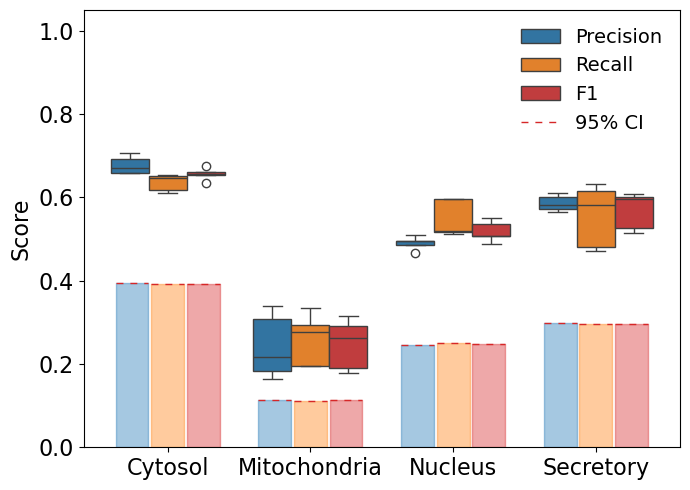

In [31]:
# Load data
cv_summary_df = pd.read_csv(cv_folder_path + f'{Set}_5FoldCV_PerClassOnly.csv')

# Setup
class_labels = ['Cytosol', 'Mitochondria', 'Nucleus', 'Secretory']
metrics = ['Precision', 'Recall', 'F1']
metric_columns = {
    'Precision': [f'Precision_C{i}' for i in range(4)],
    'Recall':    [f'Recall_C{i}' for i in range(4)],
    'F1':        [f'F1_C{i}' for i in range(4)],
}

# Construct long-form DataFrame for seaborn
plot_data = []
for metric in metrics:
    for class_idx, class_label in enumerate(class_labels):
        column_name = f"{metric}_C{class_idx}"
        for score in cv_summary_df[column_name].values:
            plot_data.append({
                'Metric': metric,
                'Class': class_label,
                'Score': score
            })

plot_df = pd.DataFrame(plot_data)

# Plot
plt.figure(figsize=(7, 5))
sns.boxplot(data=plot_df, x='Class', y='Score', hue='Metric',
            palette=['#1f77b4', '#ff7f0e', '#d62728'])

# 95% CI values (e.g., mean or reference baseline for each box)
zigzag_y = [0.39428871, 0.39192708, 0.39310435,
            0.1138976, 0.11088505, 0.11237113,
            0.24483776, 0.25053903, 0.24765558,
            0.2973352, 0.29681484, 0.29707479]

# Shading and dashed lines
n_metrics = len(metrics)
box_offsets = np.linspace(-0.25, 0.25, n_metrics)  # for 3 metrics
colors = ['#1f77b4', '#ff7f0e', '#d62728'] * 4  # same as box colors

for class_idx in range(len(class_labels)):
    for metric_idx in range(n_metrics):
        box_idx = class_idx * n_metrics + metric_idx
        x = class_idx + box_offsets[metric_idx]
        y = zigzag_y[box_idx]

        # Dashed line at zigzag_y height
        plt.hlines(y=y, xmin=x - 0.115, xmax=x + 0.115,
                   color='#d62728', linestyle=(0, (5, 5)), linewidth=1)

        # Fill under line with same metric color
        plt.fill_betweenx(y=[0, y], x1=x - 0.115, x2=x + 0.115,
                          color=colors[box_idx], alpha=0.4)

# Add custom legend handle for 95% CI
ci_line = mlines.Line2D([], [], color='#d62728', linestyle=(0, (5, 5)),
                        linewidth=1, label='95% CI')

# Grab existing handles + add 95% CI
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(ci_line)
labels.append("95% CI")

# Finalize legend and labels
plt.legend(handles=handles, labels=labels, title='', fontsize=14,
           frameon=False, loc='upper right')

plt.xlabel('')
plt.ylabel('Score', fontsize=16)
plt.ylim(0, 1.05)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()

plt.savefig(fig_bank_path + f'{Set}_5foldCV_BoxPlot.pdf', dpi=600, bbox_inches='tight')
plt.show()


### Fig: training and validation loss and accuracy

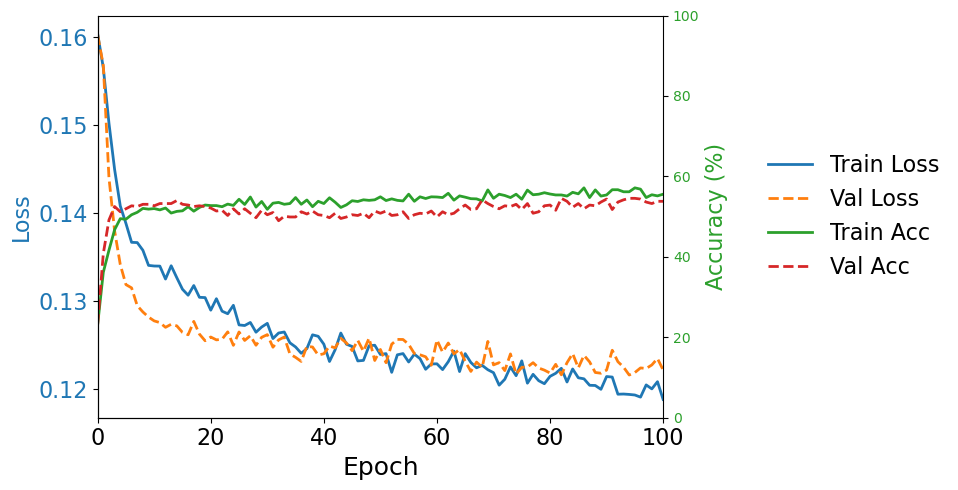

In [32]:
# Find last completed epoch
last_epoch = LossAccDF['Epoch'].max()

fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot loss on left y-axis
ax1.plot(LossAccDF['Epoch'], LossAccDF['TrainLoss'], label='Train Loss', color='tab:blue', linewidth=2)
ax1.plot(LossAccDF['Epoch'], LossAccDF['ValLoss'], label='Val Loss', color='tab:orange', linewidth=2, linestyle='--')
ax1.set_xlabel('Epoch', fontsize=18)
ax1.set_ylabel('Loss', fontsize=16, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xlim([0, last_epoch])
ax1.set_xticks(range(0, last_epoch+1, max(1, last_epoch // 5)))
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.tick_params(axis='both', which='major', labelsize=16)

# Plot accuracy on right y-axis
ax2 = ax1.twinx()
ax2.plot(LossAccDF['Epoch'], LossAccDF['TrainAcc'] * 100, label='Train Acc', color='tab:green', linewidth=2)
ax2.plot(LossAccDF['Epoch'], LossAccDF['ValAcc'] * 100, label='Val Acc', color='tab:red', linewidth=2, linestyle='--')
ax2.set_ylabel('Accuracy (%)', fontsize=16, color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.set_ylim([0, 100])

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, frameon=False, fontsize=16, loc='center left', bbox_to_anchor=(1.15, 0.5))

plt.tight_layout()
plt.savefig(Path(fig_bank_path) / f"{Set}_Loss_Acc_DualAxis.pdf", dpi=600, bbox_inches='tight')
plt.show()

### Fig: confusion matrices

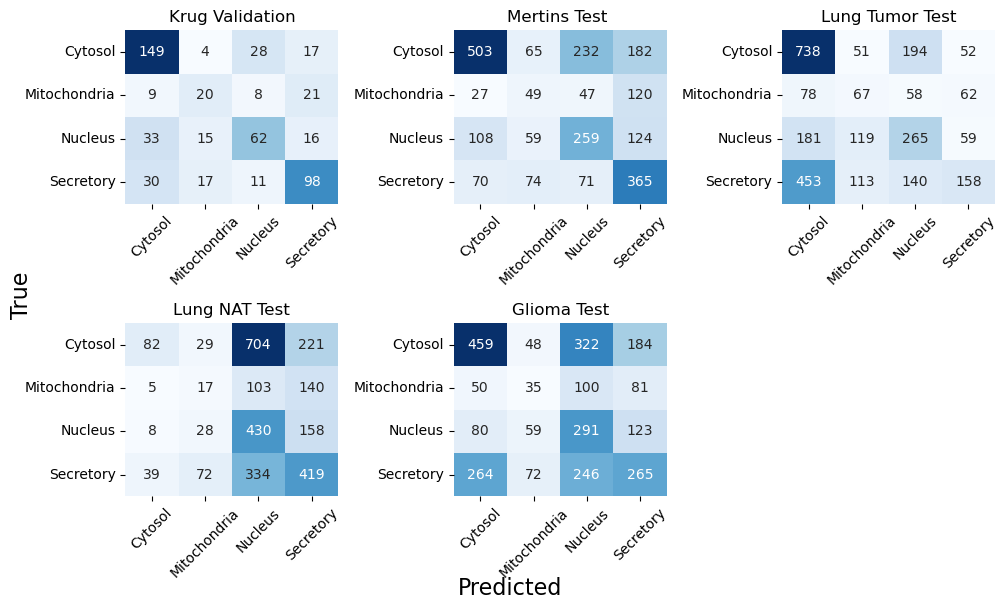

<Figure size 640x480 with 0 Axes>

In [33]:
# Set seed
set_seed(Seed)

# Get the confusion matrix and precision and recall for the validation loader and all test loaders
cf_matrix_val, precision_val, recall_val, macro_f1_val, mcc_val = calculate_metrics(val_loader, last_model)
cf_matrix_M, precision_M, recall_M, macro_f1_M, mcc_M = calculate_metrics(M_test_loader, last_model)
cf_matrix_lung_tumor, precision_lung_tumor, recall_lung_tumor, macro_f1_lung_tumor, mcc_lung_tumor = calculate_metrics(lung_tumor_test_loader, last_model)
cf_matrix_lung_nat, precision_lung_nat, recall_lung_nat, macro_f1_lung_nat, mcc_lung_nat = calculate_metrics(lung_nat_test_loader, last_model)
cf_matrix_glioma, precision_glioma, recall_glioma, macro_f1_glioma, mcc_glioma = calculate_metrics(glioma_test_loader, last_model)

# Put them into a list
cf_matrices = [cf_matrix_val, cf_matrix_M, cf_matrix_lung_tumor, cf_matrix_lung_nat, cf_matrix_glioma]
titles = ['Krug Validation', 'Mertins Test ', 'Lung Tumor Test', 'Lung NAT Test', 'Glioma Test']

# Plot the confusion matrices
plot_confusion_matrices(cf_matrices, labels=int_to_label.values(), title=titles)

# Save figure into figure bank
figure3 = plt.gcf()
figure3.savefig(Path(fig_bank_path+Set+'_Confusion_Matrices.pdf'), dpi=300)

### Fig: Precision and recall of validation and testing

/tmp/ipykernel_13287/2419985408.py:15: RuntimeWarning: divide by zero encountered in divide
  y_right = f1_score * x_right / (2 * x_right - f1_score)


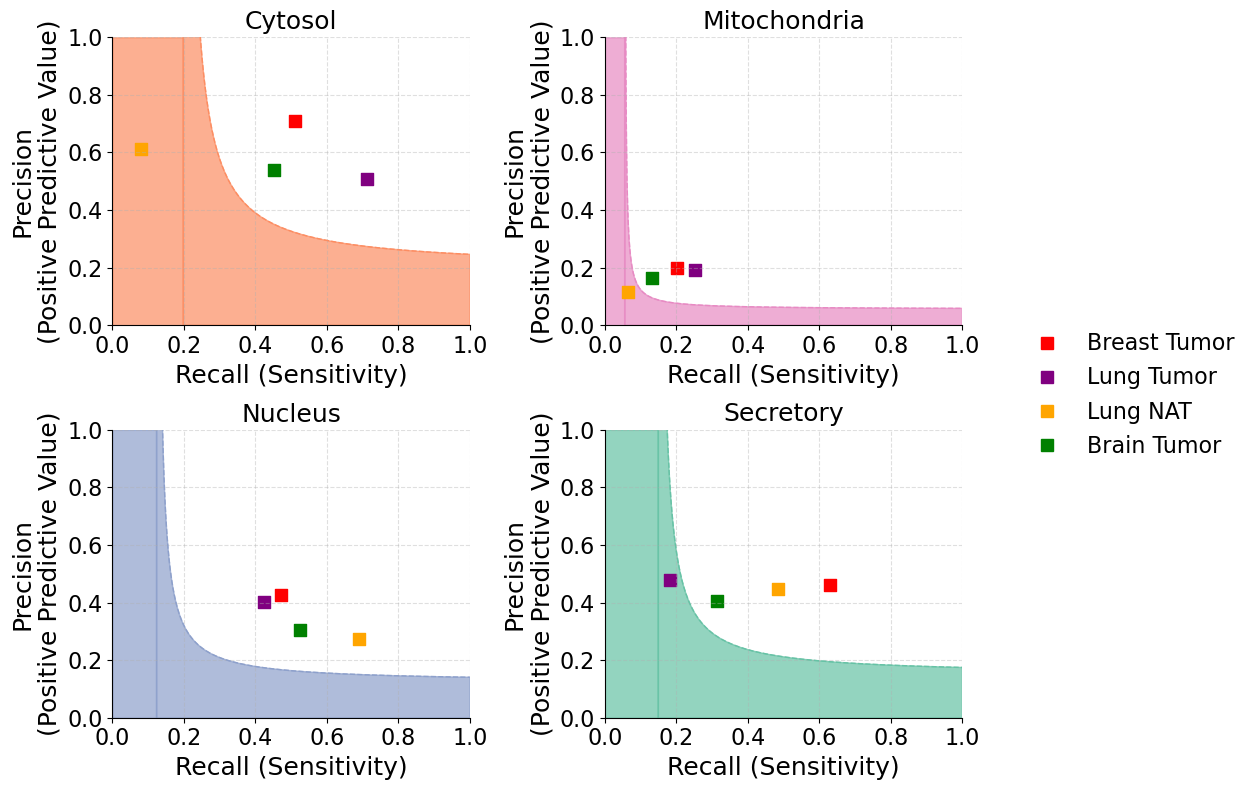

In [34]:
set_seed(Seed)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

compartment_class = ['Cytosol', 'Mitochondria', 'Nucleus', 'Secretory']
colormaps = ['#fc8d62', '#e78ac3', '#8da0cb', '#66c2a5']

for i, f1_score in enumerate(np.array([0.39506494, 0.11058946, 0.24641711, 0.29723098])):
    ax = axes[i]

    # Plot F1 curve
    x_left = np.linspace(0, f1_score / 2, 10000)
    x_right = np.linspace(f1_score / 2, 1, 10000)
    y_right = f1_score * x_right / (2 * x_right - f1_score)
    ax.plot(x_right, y_right, color=colormaps[i], linestyle='--', linewidth=1)
    ax.fill_between(x_left, 0, 1, color=colormaps[i], alpha=0.7)
    ax.fill_between(x_right, 0, y_right, color=colormaps[i], alpha=0.7)

    # Add external test points
    ax.scatter(recall_M[i], precision_M[i], s=75, color='red', edgecolors='red', marker='s', label='Mertins test set')
    ax.scatter(recall_lung_tumor[i], precision_lung_tumor[i], s=75, color='purple', edgecolors='purple', marker='s', label='LSCC Tumor')
    ax.scatter(recall_lung_nat[i], precision_lung_nat[i], s=75, color='orange', edgecolors='orange', marker='s', label='LSCC NAT')
    ax.scatter(recall_glioma[i], precision_glioma[i], s=75, color='green', edgecolors='green', marker='s', label='Glioma')

    # Plot settings
    ax.set_title(compartment_class[i], fontsize=18)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('Recall (Sensitivity)', fontsize=18)
    ax.set_ylabel('Precision\n(Positive Predictive Value)', fontsize=18)
    ax.tick_params(axis='both', labelsize=16)
    ax.grid(True, linestyle='--', alpha=0.4)

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Legend (only once per subplot)
    mertins_handle = mlines.Line2D([], [], color='red', marker='s', linestyle='None', markersize=8, label='Breast Tumor')
    lung_tumor_handle = mlines.Line2D([], [], color='purple', marker='s', linestyle='None', markersize=8, label='Lung Tumor')
    lung_nat_handle = mlines.Line2D([], [], color='orange', marker='s', linestyle='None', markersize=8, label='Lung NAT')
    glioma_handle = mlines.Line2D([], [], color='green', marker='s', linestyle='None', markersize=8, label='Brain Tumor')

# Global legend outside the subplots
fig.legend(handles=[mertins_handle, lung_tumor_handle, lung_nat_handle, glioma_handle],
           loc='center left', bbox_to_anchor=(1.01, 0.5), fontsize=16, frameon=False)

# Tight layout
plt.tight_layout()  # reserve space on the right

# Save figure at high quality
fig.savefig(Path(fig_bank_path) / f"{Set}_Precision_Recall_F1curve.pdf", dpi=600, bbox_inches='tight')

In [35]:
# export dataframes
LossAccDF.to_excel(Path(fig_bank_path + Set+ f'_LossAccDF.xlsx'), index=False)
PrecisionRecallDF.to_excel(Path(fig_bank_path + Set+ f'_PrecisionRecallDF.xlsx'), index=False)